In [138]:
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
import copy

In [2]:
CLASSES = {}
with open("data/classes.names", "r") as f:
    for i, line in enumerate(f.readlines()):
        CLASSES[i] = line.strip()
CLASSES

{0: 'prohibitory', 1: 'danger', 2: 'mandatory', 3: 'other'}

In [94]:
IMG_SIZE = 448
NB_CELL = 7
CELL_SIZE = IMG_SIZE/NB_CELL
NB_BOXES = 2
DEPTH = 3
NB_CLASSES = len(CLASSES)

In [159]:
imgs = glob.glob('data/ts/ts/*.jpg')
labs = glob.glob('data/ts/ts/*.txt')
imgs = sorted(imgs, key= lambda x: x[11: 16]) # file_name 12345.jpg, begin index 11 in path
labs = sorted(labs, key= lambda x: x[11: 16])
print(imgs[:3])
print(labs[:3])

['data/ts/ts/00000.jpg', 'data/ts/ts/00001.jpg', 'data/ts/ts/00002.jpg']
['data/ts/ts/00000.txt', 'data/ts/ts/00001.txt', 'data/ts/ts/00002.txt']


In [153]:
def show_IMG_BOXES(img_origin, lab, grid=True, from_pred=False):
    img = copy.deepcopy(img_origin) # avoid overwritting
    if not from_pred:
        boxes = []
        for i in range(NB_CELL):
            for j in range(NB_CELL):
                if lab[i, j, 0] == 1: # object
                    coord = lab[i, j, 1:5]
                    x_center, y_center, w, h = coord[0], coord[1], coord[2], coord[3]
                    x = x_center*CELL_SIZE+i*CELL_SIZE # reverse to true value [0-IMG_SIZE]
                    y = y_center*CELL_SIZE+j*CELL_SIZE # reverse to true value [0-IMG_SIZE]
                    w = w*IMG_SIZE
                    h = h*IMG_SIZE
                    top_left = (int(x-w/2), int(y-h/2))
                    bottom_right = (int(x+w/2), int(y+h/2))
                    upper_middle = (int(x), int(y-h/2)-5) # to put text, move a bit to the top by 5 pixel
                    classes = lab[i, j, -NB_CLASSES:]
                    cl = CLASSES[np.argmax(classes)]
                    boxes.append([cl, top_left, bottom_right, upper_middle])
    # plot box and class
    for box in boxes:
        img = cv2.rectangle(img, box[1], box[2], color=(255, 0, 0), thickness=2)
        img = cv2.putText(img, text=box[0], org=box[-1], fontFace=cv2.FONT_HERSHEY_SIMPLEX,\
                           fontScale= 0.5,\
                              color=(255, 0, 0),\
                                thickness=1)

    if grid:
        scale = IMG_SIZE//NB_CELL
        for i in range(scale):
            for j in range(scale):
                img = cv2.rectangle(img,\
                                    ((i * scale), (j * scale)), (((i+1) * scale),((j+1) * scale)),\
                                    color=(100,0,200), thickness=1)
    plt.imshow(img)


In [154]:
def prepareDataset(imgs, labs):
    assert len(imgs) == len(labs)
    N = len(imgs)
    X = np.zeros((N, IMG_SIZE, IMG_SIZE, DEPTH), dtype=np.float32)
    Y = np.zeros((N, NB_CELL, NB_CELL, 5+NB_CLASSES)) # p, x, y, w ,h, classes
    for i, (path_img,  path_lab) in enumerate(zip(imgs, labs)):
        #### IMAGE
        img = cv2.imread(path_img)
        # Simple preprocessing image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # resize
        #img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX) # normalize
        # normalize by dividing by 255
        X[i] = img/255.
        #### LABEL

        boxes = []
        classes = []

        with open(path_lab, 'r') as f:
            for line in f:
                line = line.strip().split(" ")
                boxes.append([float(x) for x in line[1:]]) # string to float
                classes.append(int(line[0]))
        
        boxes = np.array(boxes)
        for box, cl in zip(boxes, classes):
            # one hot coding
            cl_array = [0]*NB_CLASSES
            cl_array[cl] = 1
            # x, y, w, h are already scaled to img size [0-1]
            x, y, w, h = box[0]*IMG_SIZE, box[1]*IMG_SIZE, box[2], box[3] # rescale to true value of x, y
            inx_x, inx_y = int(x/CELL_SIZE), int(y/CELL_SIZE) # inx of cell is true coord divides by SIZE of cell
            x_center, y_center = (x-inx_x*CELL_SIZE)/CELL_SIZE, (y-inx_y*CELL_SIZE)/CELL_SIZE # coord relative to cell
            # make Y: 1 is I_object, we dont scale w, h because the box size is not relative to cell (can bigger then cell)
            # each cell can only detect 1 object so it can overwrite, need bigger number of cells to deal with this
            Y[i, inx_x, inx_y] = 1, x_center, y_center, w, h, *cl_array
    return X, Y

In [137]:
X, Y = prepareDataset(imgs, labs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


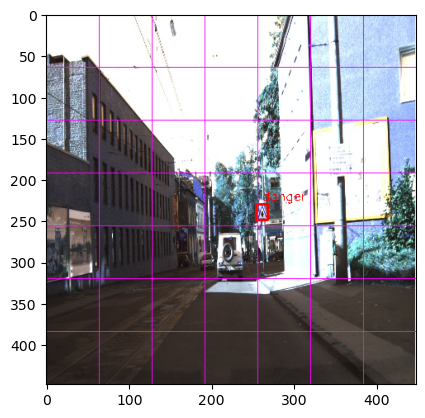

In [160]:
show_IMG_BOXES(X[0], Y[0], grid=True)